### Importing Packages

In [37]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
import numpy  as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

from gsw import p_from_z
from gsw import pot_rho_t_exact as prho

import seaborn as sns
# sns.reset_defaults()
sns.set_theme(style='darkgrid')
# sns.set_context('talk')

import datetime

from scipy import interpolate, ndimage
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import sys
import subprocess

from datetime import datetime, date

import glob
import os

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath("D:/00_Masters/00_Work/"))
from Utils.compute_histogram import *
from Utils.inertP import *
from Utils.rmse import *
from Utils.uv2veldire import *
from Utils.veldire2uv import *

In [2]:
sns.set_theme(style='darkgrid')

### Loading database

##### Dataset do Mercator

In [13]:
for i in range(2014,2020,1):
    merc_path = glob.glob("D:/00_Masters/01_Dados/Mercator/Merc_"+str(i)+"*.nc")
    ds = xr.open_mfdataset(merc_path)
    ds = ds.sel(latitude=-12.58, longitude=-37.92, method='nearest')
    _, index = np.unique(ds['time'], return_index=True)
    ds = ds.isel(time=index)

    if i==2014:
        merc = ds
        del ds
    else:
        merc = xr.merge([merc,ds])

merc = merc.sel(time=slice('2014-11-25', '2019-12-31'))

In [114]:
merc

<xarray.Dataset>
Dimensions:    (time: 1863, depth: 29)
Coordinates:
  * time       (time) datetime64[ns] 2014-11-25T12:00:00 ... 2019-12-31T12:00:00
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 222.5 266.0 318.1
    latitude   float32 -12.58
    longitude  float32 -37.92
Data variables:
    vo         (time, depth) float32 dask.array<chunksize=(1500, 29), meta=np.ndarray>
    uo         (time, depth) float32 dask.array<chunksize=(1500, 29), meta=np.ndarray>
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2020/11/28 14:22:19 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

#### SimCosta PF

In [42]:
# Dados Fundeio
PF = pd.read_csv('D:/00_Masters/01_Dados/SiMCosta_BA2/SIMCOSTA_BA-2_CURR_2014-11-25_2021-03-23.CSV',sep='\t')

PF.index = pd.to_datetime(PF[["YEAR", "MONTH", "DAY","HOUR"]])
PF.drop(columns = ['YEAR','MONTH','DAY','HOUR','MINUTE','SECOND'],inplace=True)

PF = PF[:'2019-12-31']

testes

## Analises

#### Comparing Datasets

#### Calculo do período inericial para filtragem

In [6]:
P = inertP(lat=12.5)

#### Glorys X SiMCosta

    Separando as profundidades e removendo o periodo subinercial (55h)

In [126]:
# merc  = merc.drop_vars(names=['mlotst','thetao','bottomT','zos','so'])
Depth_30 = merc.sel(depth=30,method='nearest')
Depth_30 = Depth_30.drop(['latitude','longitude','depth'])
Depth_30 = Depth_30.to_dataframe()
Depth_30['speed'], Depth_30['direction'] = uv2veldire(Depth_30['uo'],Depth_30['vo'],corr_val=40,)
Depth_30['direction'][Depth_30['direction']<0] += 360
Depth_30['u'], Depth_30['v'] = veldire2uv(Depth_30['speed'], Depth_30['direction'],par='cor')
Depth_30 = Depth_30.rolling(str((P//24)+1)+'D',center=True).mean()

PF_day = pd.DataFrame(PF.index,columns=['date'])
PF_day.index = PF_day['date']
PF_day = PF_day.drop(axis=1,columns=['date'])
PF_day['speed'] = PF['Avg_Cell(4)_mag'] #* 0.5144
PF_day['direction'] = PF['Avg_Cell(4)_dir'] - 40
PF_day['direction'][PF_day['direction']<0] += 360
PF_day['u'], PF_day['v'] = veldire2uv(PF_day['speed'], PF_day['direction'],par='cor')
PF_day = PF_day.rolling(str((P//24)+1)+'D',center=True).mean()
PF_day = PF_day.resample('1D').mean().fillna(method='bfill')

<AxesSubplot:xlabel='time'>

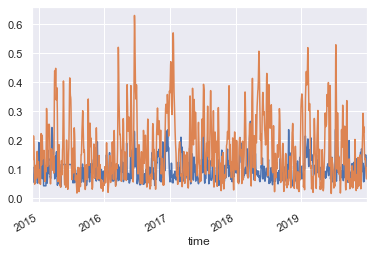

In [127]:
PF_day['speed'].plot()
Depth_30['speed'].plot()

    Primeira validacao
        Estatistica basica 
        plot de densidade e corelação

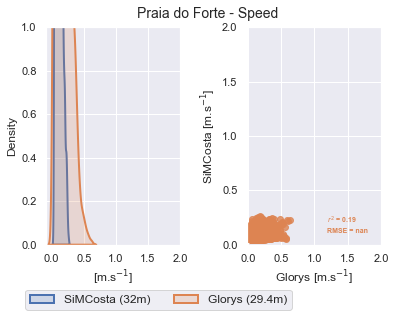

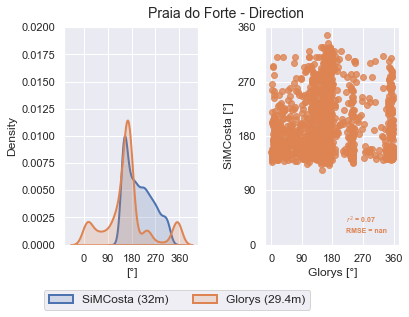

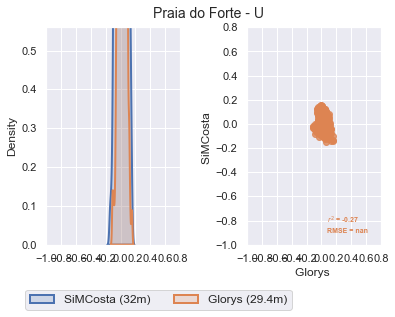

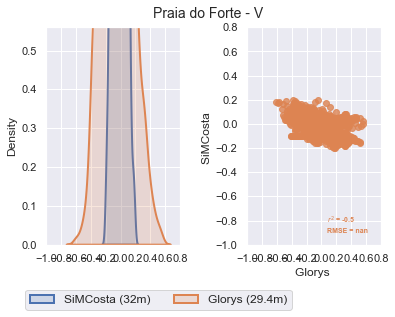

In [128]:
vars = ['speed','direction','u','v']
nam = ['SiMCosta (32m)', 'Glorys (29.4m)']
path_output = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/'

schema = [PF_day,Depth_30]

f1 = open(os.path.join(path_output, './Stats-Curr_Glorys_SiMCosta.txt') , 'w')
for v in vars:
   for i in range(0,len(schema)):
      print('\n',nam[i],' - Variable: ',v,file=f1)
      print(stats.describe(schema[i][v],nan_policy='omit'), ('std= '+str(np.std(schema[i][v]))),file=f1)
f1.close()

f2 = open(os.path.join(path_output, './R2-Curr_Glorys_SiMCosta.txt') , 'w')
R = []
RMSE = []
for v in vars:
   for i in range(0,len(schema)-1):
      res = stats.pearsonr(x=schema[i+1][v],y=schema[0][v])
      err = rmse(schema[i+1][v],schema[0][v])
      print('\n',' - Variable: ',v,file=f2)
      print('Pearson Corr. -', nam[i+1], nam[0],file=f2)
      print(res,file=f2)
      print('Root Mean Square Error RMSE -', nam[i+1], nam[0],file=f2)
      print(err,file=f2)
      R.append(np.round(res[0],2))
      RMSE.append(np.round(err,2))
f2.close()

''' 
FIGURA COM SeaBorn

'''
for ind,v in enumerate(vars):
   fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
   cmap = sns.color_palette(as_cmap=True)

   with sns.axes_style("darkgrid"):
      for i in range(0,len(schema)):
            ax1 = sns.kdeplot(data=schema[i][v], x = schema[i][v], fill=True, alpha=.2, linewidth=2, bw=0.2, ax=ax1)

   with sns.axes_style("darkgrid"):
      for i in range(0,len(schema)-1):
            ax2 = sns.regplot(x=schema[i+1][v], y=schema[0][v], color=cmap[i+1], fit_reg = False, ax=ax2)

   fig.subplots_adjust(wspace=0.5)
   fig.suptitle('Praia do Forte - '+v.format().capitalize(),fontsize=14,y=.95)

   if str(v) == 'speed':
      unit = "[m.s$^{-1}$]"
      ax1.set_xticks(np.arange(0,2.5,.5))
      ax2.set_xticks(np.arange(0,2.5,.5))
      ax2.set_yticks(np.arange(0,2.5,.5))
      ax1.set_ylim(0,1)
   elif str(v) == 'direction':
      unit = "[°]"
      ax1.set_xticks(np.arange(0,361,90))
      ax2.set_xticks(np.arange(0,361,90))
      ax2.set_yticks(np.arange(0,361,90))
      ax1.set_ylim(0,0.02)
   else:
      unit = ""
      ax1.set_xticks(np.arange(-1,1,.2))
      ax2.set_xticks(np.arange(-1,1,.2))
      ax2.set_yticks(np.arange(-1,1,.2))
      ax1.set_ylim(0,.56)

   ax1.set_xlabel(unit)
   ax2.set_xlabel('Glorys ' + unit)
   ax2.set_ylabel('SiMCosta ' + unit)

   ax1.legend(nam,fontsize=12, bbox_to_anchor = (-.2,-.18),loc='upper left', ncol=3)

   ax2.annotate("$r^2$ = " + str(R[ind]), fontsize=7,color=cmap[1],
               xy=(.6, .1), xycoords='axes fraction',fontweight="bold")
   ax2.annotate("RMSE = " + str(RMSE[ind]), fontsize=7,color=cmap[1],
               xy=(.6, .055), xycoords='axes fraction',fontweight="bold")



# fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
# cmap = sns.color_palette(as_cmap=True)

# with sns.axes_style("darkgrid"):
#    for i in range(0,len(schema)):
#       ax1 = sns.kdeplot(data=schema[i],x = schema[i] ,fill=True, alpha=.2, linewidth=2, bw=0.2, ax=ax1)

# with sns.axes_style("darkgrid"):
#    for i in range(0,len(schema)-1):
#       ax2 = sns.regplot(x=schema[i+1],y=schema[0], color=cmap[i+1], fit_reg = False, ax=ax2)

# fig.subplots_adjust(wspace=0.4)
# fig.suptitle('Praia do Forte',fontsize=14,y=.95)

# ax1.set_xlabel('Temp. (°C)', fontsize=12)
# ax1.set_xlim(22.5,30.5)
# ax1.set_xticks([24,26,28,30])
# ax1.set_ylim(0,.6)
# ax1.legend(nam,fontsize=12, bbox_to_anchor = (-.385,-.18),loc='upper left', ncol=3)


# ax2.set_ylabel("Temp. $\it{in situ}$", fontsize=12)
# ax2.set_xlabel('Modelled Temp. (°C)', fontsize=12)
# ax2.set_ylim(22.5,30.5)
# ax2.set_yticks([24,26,28,30])
# ax2.set_xlim(22.5,30.5)
# ax2.set_xticks([24,26,28,30])

# ax2.annotate("$r^2$ = " + str(R[0]), fontsize=7,color=cmap[1],
#             xy=(.65, .105), xycoords='axes fraction',fontweight="bold")
# ax2.annotate("RMSE = " + str(RMSE[0]), fontsize=7,color=cmap[1],
#             xy=(.65, .075), xycoords='axes fraction',fontweight="bold")

# plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF-Total.png', format='png', dpi=300, bbox_inches='tight')


    Serie temporal


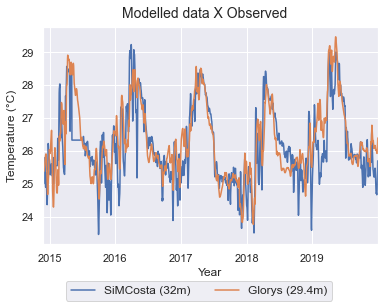

In [14]:
schema = [PF_day.Temperature,m29.thetao]
nam = ['SiMCosta (32m)', 'Glorys (29.4m)']

fig, ax1 = plt.subplots(nrows=1, ncols=1, gridspec_kw={'width_ratios':[2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)
fig.suptitle('Modelled data X Observed',fontsize=14,y=.95)

with sns.axes_style("darkgrid"):
    for i in range(0,len(schema)):
        ax1 = sns.lineplot(x=schema[i].index,y=schema[i],ax=ax1)

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.05,-.14),loc='upper left', ncol=3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF-Serie.png', format='png', dpi=300, bbox_inches='tight')

    MUR x Glorys

In [15]:
m0 = merc['thetao'].sel(depth=0,method='nearest')
m0 = m0.to_dataframe()
m0 = m0.rolling(str((P//24)+1)+'D',center=True).mean()

sst = mur['analysed_sst'].to_dataframe()
sst = sst.rolling(str((P//24)+1)+'D',center=True).mean()

    Primeira validacao
        Estatistica basica 
        plot de densidade e corelação

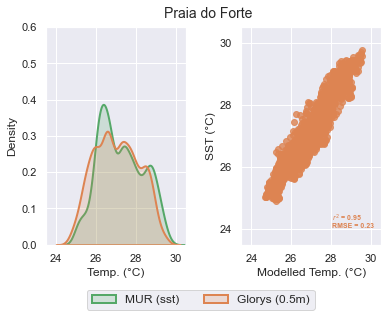

In [26]:
schema = [sst.analysed_sst,m0.thetao]
nam = ['MUR (sst)', 'Glorys (0.5m)']
path_output = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/'

f1 = open(os.path.join(path_output, './Stats_Glorys_MUR.txt') , 'w')
for i in range(0,len(schema)):
   print('\n',nam[i], file=f1)
   print(stats.describe(schema[i]), ('std= '+str(np.std(schema[i]))),file=f1)
f1.close()

f2 = open(os.path.join(path_output, './R2_Glorys_MUR.txt') , 'w')
R = []
RMSE = []
for i in range(0,len(schema)-1):
      res = stats.pearsonr(x=schema[i+1],y=schema[0])
      err = rmse(schema[i+1][i],schema[0][i])
      print('\nPearson Corr. -', nam[i+1], nam[0],file=f2)
      print(res,file=f2)
      print(err,file=f2)

      R.append(np.round(res[0],2))
      RMSE.append(np.round(err,2)) 
f2.close()

''' 
FIGURA COM SeaBorn

'''
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)

with sns.axes_style("darkgrid"):
   for i,c in zip(range(0,len(schema)),[2,1]):
      ax1 = sns.kdeplot(data=schema[i],x = schema[i] ,fill=True, color=cmap[c], alpha=.2, linewidth=2, bw=0.2, ax=ax1)

with sns.axes_style("darkgrid"):
   for i in range(0,len(schema)-1):
      ax2 = sns.regplot(x=schema[i+1],y=schema[0], color=cmap[i+1], fit_reg = False, ax=ax2)

fig.subplots_adjust(wspace=0.4)
fig.suptitle('Praia do Forte',fontsize=14,y=.95)

ax1.set_xlabel('Temp. (°C)', fontsize=12)
ax1.set_xlim(23.5,30.5)
ax1.set_xticks([24,26,28,30])
ax1.set_ylim(0,.6)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.25,-.18),loc='upper left', ncol=3)


ax2.set_ylabel("SST (°C)", fontsize=12)
ax2.set_xlabel('Modelled Temp. (°C)', fontsize=12)
ax2.set_ylim(23.5,30.5)
ax2.set_yticks([24,26,28,30])
ax2.set_xlim(23.5,30.5)
ax2.set_xticks([24,26,28,30])

ax2.annotate("$r^2$ = " + str(R[0]), fontsize=7,color=cmap[1],
            xy=(.65, .105), xycoords='axes fraction',fontweight="bold")
ax2.annotate("RMSE = " + str(RMSE[0]), fontsize=7,color=cmap[1],
            xy=(.65, .075), xycoords='axes fraction',fontweight="bold")

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF_superficie-Total.png', format='png', dpi=300, bbox_inches='tight')


    Serie temporal


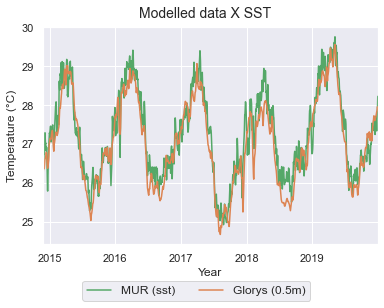

In [27]:
schema = [sst.analysed_sst,m0.thetao]
nam = ['MUR (sst)', 'Glorys (0.5m)']

fig, ax1 = plt.subplots(nrows=1, ncols=1, gridspec_kw={'width_ratios':[2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)
fig.suptitle('Modelled data X SST',fontsize=14,y=.95)

with sns.axes_style("darkgrid"):
    for i,c in zip(range(0,len(schema)),[2,1]):
        ax1 = sns.lineplot(x=schema[i].index,y=schema[i], color=cmap[c], ax=ax1)

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.1,-.14),loc='upper left', ncol=3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF_superficie-Serie.png', format='png', dpi=300, bbox_inches='tight')